In [2]:
# import  os
# #set visibile cuda
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corner import corner

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
import emcee
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import anneal_dsm_score_estimation
from tools.score_net import score_model_cond,score_model
from tools.sampling import annealed_langevin_dynamic_sampler

Logistic regression model
$$
\begin{aligned}
y_{j}& \sim Bernoulli(\eta_j(\boldsymbol{\xi}))  \\
\eta_{j}(\boldsymbol\xi)& =logit^{-1}\{\alpha+\beta x_j\}=\frac1{1+\exp\{-(\alpha+\beta x_j)\}}. 
\end{aligned}
$$
likelihood
$$
p(y_j|\boldsymbol{\xi})=\eta_j(\boldsymbol{\xi})^{y_j}(1-\eta_j(\boldsymbol{\xi}))^{1-y_j}\\
\log p(\boldsymbol{y}|\boldsymbol{\xi})=\sum_{j=1}^{J}\left\{y_j\eta_j(\boldsymbol{\xi})+(1-y_j)\log(1-\eta_j(\boldsymbol{\xi}))\right\}
$$

score
$$
\begin{aligned}
&\frac{\partial}{\partial\beta}\operatorname{log}p(\boldsymbol{y}|\boldsymbol{\xi}) =\sum_{j=1}^{J}\bigg\{x_{j}(y_{j}-\eta_{j}(\xi))\bigg\} \\
&\frac{\partial}{\partial\alpha}\operatorname{log}p(\boldsymbol{y}|\boldsymbol{\xi}) =\sum_{j=1}^{J}\Bigg\{(y_{j}-\eta_{j}(\boldsymbol{\xi}))\Bigg\}. 
\end{aligned}
$$

fisher
$$
F(\boldsymbol\xi)=\sum_{j=1}^{J}\eta_j(\boldsymbol\xi)(1-\eta_j(\boldsymbol\xi))\begin{pmatrix}1&x_j\\x_j&x_j^2.\end{pmatrix}
$$

only consider 1-d obs case here


In [127]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

N_obs_dim=10
factor=np.random.uniform(0,1,N_obs_dim)

def logistic_simulator(thetas):
    alpha, beta= thetas[:,0],thetas[:,1]
    prob = sigmoid(alpha[:,None]+beta[:,None]*factor)
    return np.random.binomial(1, prob)

def log_likelihood(thetas, x):
    alpha, beta= thetas[:,0],thetas[:,1]
    prob = sigmoid(alpha[:,None]+beta[:,None]*factor)
    likelihood = x * prob + (1 - x) * np.log(1 - prob)
    return likelihood.sum(1)

def true_fisher_score(thetas,x):
    alpha, beta= thetas[:,0],thetas[:,1]
    prob = sigmoid(alpha[:,None]+beta[:,None]*factor)
    d_alpha =(x - prob).sum(1)
    d_beta = (factor * (x - prob)).sum(1)
    return np.array([d_alpha, d_beta]).T

def true_fisher_information(thetas):
    alpha, beta= thetas[:,0],thetas[:,1]
    prob = sigmoid(alpha[:,None]+beta[:,None]*factor)

    F_00 = np.sum(prob * (1 - prob), axis=1)
    F_01 = np.sum(prob * (1 - prob) * factor, axis=1)
    F_10 = np.sum(prob * (1 - prob) * factor, axis=1)
    F_11 = np.sum(prob * (1 - prob) * factor**2, axis=1)

    F = np.zeros((thetas.shape[0], 2, 2))
    F[:, 0, 0] = F_00
    F[:, 0, 1] = F_01
    F[:, 1, 0] = F_10
    F[:, 1, 1] = F_11

    return F

In [128]:
thetas = np.random.normal(0,1,(100,2))
X = logistic_simulator(thetas)

In [129]:
X.shape

(100, 10)

In [130]:
thetas_prior_param=[0,1]
def prior_thetas(n_samples):
    thetas = np.random.normal(thetas_prior_param[0],thetas_prior_param[1],(n_samples,2))  
    return thetas

#score for guassian with respect to x
def gaussian_sample_score(thetas_prior_param, thetas):
    score= ((thetas_prior_param[:,0]-thetas)/thetas_prior_param[:,1]**2)
    return score

In [131]:
thetas= prior_thetas(10000)
samples = logistic_simulator(thetas)

#generate one sample for posterior test
test_theta = np.array([[0.2,0.2]])
obs = logistic_simulator(test_theta)   

In [132]:
obs

array([[0, 0, 1, 0, 1, 1, 1, 0, 1, 1]])

In [133]:
#use emcee to sample from the posterior

def guassian_log_likelihood(thetas, x):
    mu, sigma= thetas[0],thetas[1]
    return -0.5*np.log(2*np.pi*sigma**2)-0.5*(x-mu)**2/sigma**2

def log_likelihood(thetas, x):
    alpha, beta= thetas[0],thetas[1]
    prob = sigmoid(alpha+beta*factor)
    likelihood = x * prob + (1 - x) * np.log(1 - prob)
    return likelihood.sum()

def prior_log_prob(thetas):
    alpha, beta= thetas[0],thetas[1]
    return guassian_log_likelihood(thetas_prior_param,alpha)+guassian_log_likelihood(thetas_prior_param,beta)

def log_posterior(thetas, x):
    return log_likelihood(thetas,x) + prior_log_prob(thetas)

ndim, nwalkers = 2, 10
nsteps, nburn = 10000, 100   
pos = np.array([test_theta[0] + 1e-1*np.random.randn(ndim) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[obs])

sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████| 10000/10000 [00:05<00:00, 1881.42it/s]


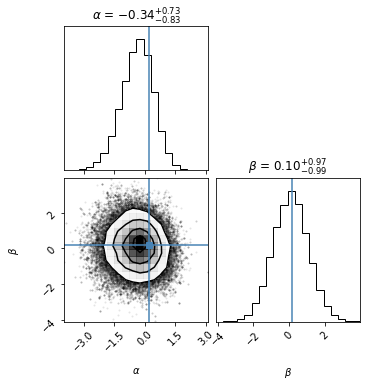

In [134]:
ref_pos= sampler.chain[:,nburn:,:].reshape(-1,ndim)
corner(ref_pos,labels=[r'$\alpha$',r'$\beta$'],show_titles=True,truths=test_theta[0]);

### Posterior Score Fitting

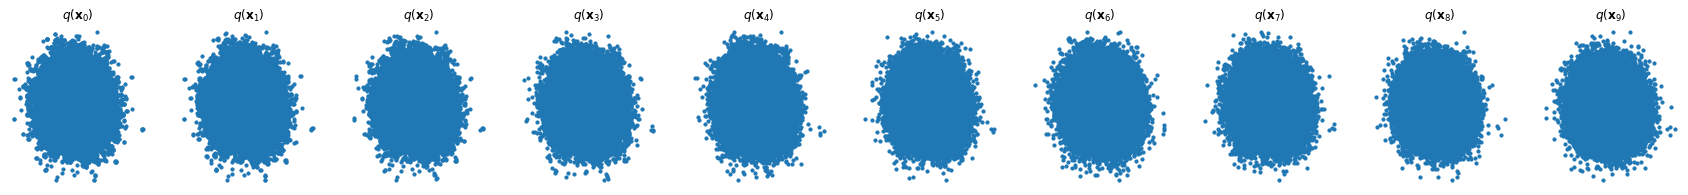

In [135]:
ns=noise_scheduler(1e-5,1e-1,10,schedule='sigmoid',var_norm=False)
ns.visualize_noise(torch.tensor(ref_pos))

In [136]:
ns.sigmas

tensor([0.0160, 0.0307, 0.0588, 0.1092, 0.1842, 0.2571, 0.2968, 0.3107, 0.3148,
        0.3158])

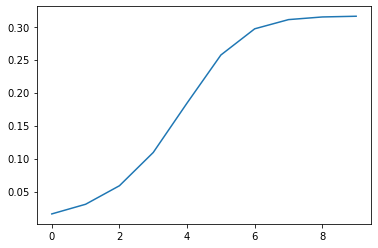

In [137]:
ns.plot_sigmas()

In [142]:
import torch
import torch.nn as nn


import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, num_classes):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(num_classes, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
    
class score_model_condint(nn.Module):
    def __init__(self, num_classes,x_dim,x_cond_dim):
        super().__init__()
        self.x_cond_emb=nn.Linear(x_cond_dim,x_cond_dim)
        self.lin1 = ConditionalLinear(x_dim+x_cond_dim, 128, num_classes)
        self.lin2 = ConditionalLinear(128, 128, num_classes)
        self.lin3 = ConditionalLinear(128, 128, num_classes)
        self.lin4 = nn.Linear(128, x_dim)
    
    def forward(self, x,x_cond, y):
        x_cond = self.x_cond_emb(x_cond)  
        x = torch.cat([x,x_cond],dim=1)
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

In [143]:
pos_model = score_model_condint(100,x_dim=2,x_cond_dim=10).to(device)
optimizer = optim.Adam(pos_model.parameters(), lr=1e-3)

In [144]:
samples.shape

(10000, 10)

In [145]:
epochs=1000
# batch = (torch.tensor(samples, dtype=torch.float32).to(device),torch.tensor(thetas, dtype=torch.float32).to(device)
dataset=torch.tensor(samples).float().to(device)
thetas=torch.tensor(thetas).float().to(device)
batch_size=1000
for epoch in range(epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = thetas[indices]
        batch_x_cond = dataset[indices]

        labels = torch.randint(0, ns.n_steps, (batch_x.shape[0],)).to(device)

        loss = anneal_dsm_score_estimation(pos_model, batch_x, labels, ns,samples_cond=batch_x_cond)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if ((epoch % 100) == 0):
        print(loss.item())

/tmp/ipykernel_2093203/3508693251.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


1.0084638595581055
0.9106286764144897
0.9109089970588684
0.9065682291984558
0.9196321964263916
0.85459965467453
0.9242117404937744
0.9592140913009644
0.9347891211509705
0.9586498737335205


In [146]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=pos_model, 
                                            device=device, 
                                            eps = 1e-5)

In [147]:
init_point=torch.tensor(prior_thetas(10000)).float().to(device)

sample_cond=torch.tensor(np.repeat(obs,10000,axis=0),dtype=torch.float32).to(device)

dynamic=sampler.sample(init_point,sample_cond=sample_cond)

# fig=corner(dynamic[-1].cpu().numpy());
# corner(ref_pos,fig=fig,color='red');

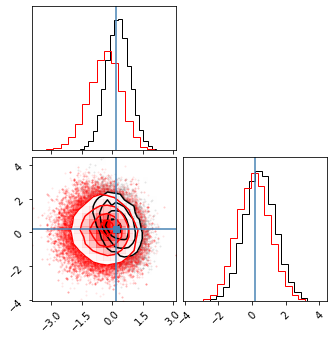

In [148]:
fig=corner(dynamic[-1].cpu().numpy(),hist_kwargs={'density':True});
corner(ref_pos,fig=fig,color='red',hist_kwargs={'density':True},truths=test_theta[0]);

### Prior Score fitting

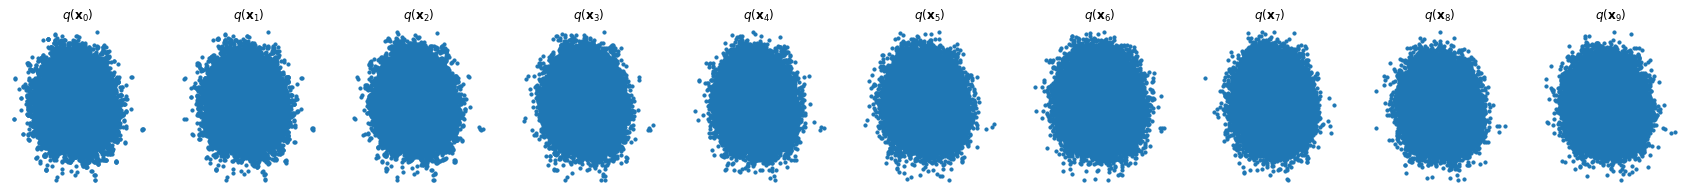

In [149]:
ns=noise_scheduler(1e-5,1e-1,10,schedule='sigmoid',var_norm=False)
ns.visualize_noise(torch.tensor(ref_pos))

In [150]:
# Our approximation model
prior_model = score_model(ns.n_steps,2).to(device)
# Create ADAM optimizer over our model
optimizer = optim.Adam(prior_model.parameters(), lr=1e-3)

In [151]:
epochs=1000

thetas=torch.tensor(thetas).float().to(device)
batch_size=1000

for epoch in range(epochs):
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch = thetas[indices]

        labels = torch.randint(0, ns.n_steps, (batch.shape[0],)).to(device)
        loss = anneal_dsm_score_estimation(prior_model, batch, labels, ns)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if ((epoch % 100) == 0):
        print(loss.item())

/tmp/ipykernel_2093203/1804625743.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas=torch.tensor(thetas).float().to(device)


1.0726944208145142
0.9250273704528809
0.9611947536468506
0.9538885951042175
0.9808958172798157
0.9713912606239319
0.990203320980072
0.9772167205810547
0.9380011558532715
0.9918546676635742


In [152]:
sampler = annealed_langevin_dynamic_sampler(sigmas=ns.sigmas, 
                                            n_iter_each_T=1000 , 
                                            score_fn=prior_model, 
                                            device=device, 
                                            eps = 1e-5)

init_point=torch.randn(10000,2).to(device)
dynamic=sampler.sample(init_point)

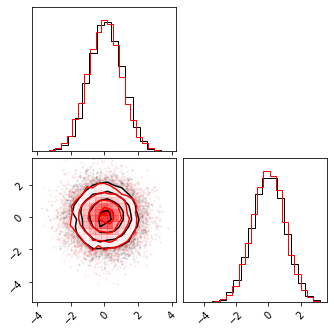

In [153]:
fig=corner(dynamic[-1].cpu().numpy(),hist_kwargs={'density':True});
corner(thetas.detach().cpu().numpy(),fig=fig,color='red',hist_kwargs={'density':True});

### Fisher Information Estimation

In [154]:
def estimate_fisher_score(x,theta):
    labels=torch.ones(x.shape[0]).long().to(device)*0
    
    with torch.no_grad():
        fs=pos_model(theta,x,labels)-prior_model(theta,labels)

    return fs.cpu().numpy()

def estimate_fisher_information(theta,N_trial=10000):

    true_thetas = torch.tensor(np.repeat(theta, N_trial, axis=0)).float()
    true_thetas_samples = logistic_simulator(true_thetas)

    #calcuate the fisher score at every sample in true_thetas_samples
    temp_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))
    #estimate fisher matrix through averaging
    estimated_fm=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

    return estimated_fm
    

(-1.0, 1.0)

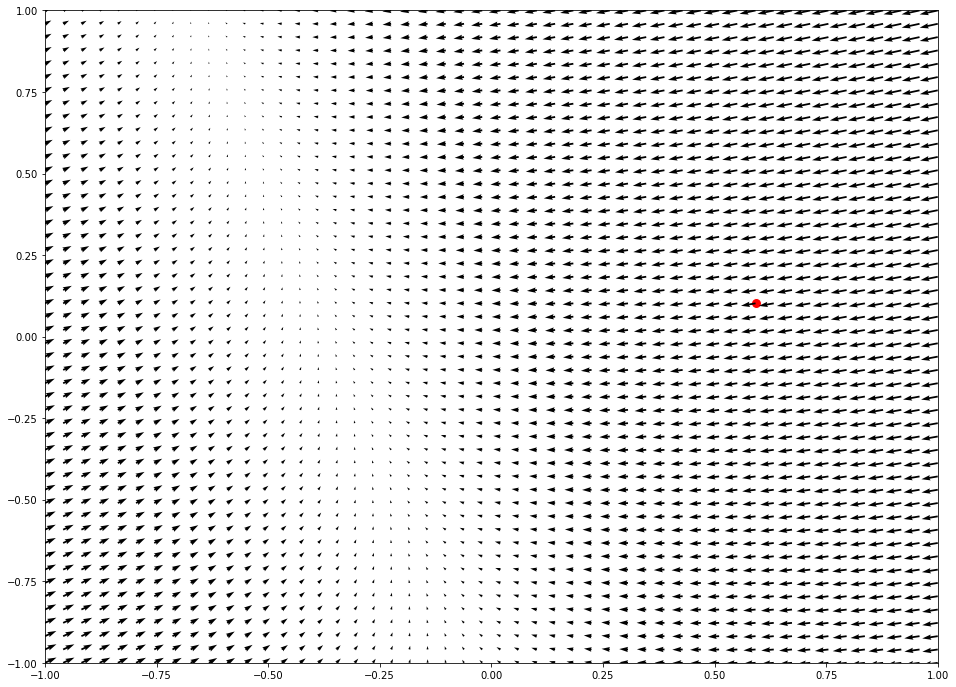

In [157]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)), axis=-1).reshape(-1, 2)
idx = np.random.randint(2500)
obs = np.repeat(logistic_simulator(xx[idx][None,:]),xx.shape[0],axis=0)

true_fs=true_fisher_score(xx,obs)

scores_norm = np.linalg.norm(true_fs, axis=-1, ord=2, keepdims=True)
scores_log1p = true_fs / (scores_norm + 1e-9) * np.log1p(scores_norm)

# Perform the plots
plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.scatter(*xx[idx], color='red', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
# plt.quiver(*xx.T, *true_fisher_score.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

(-1.0, 1.0)

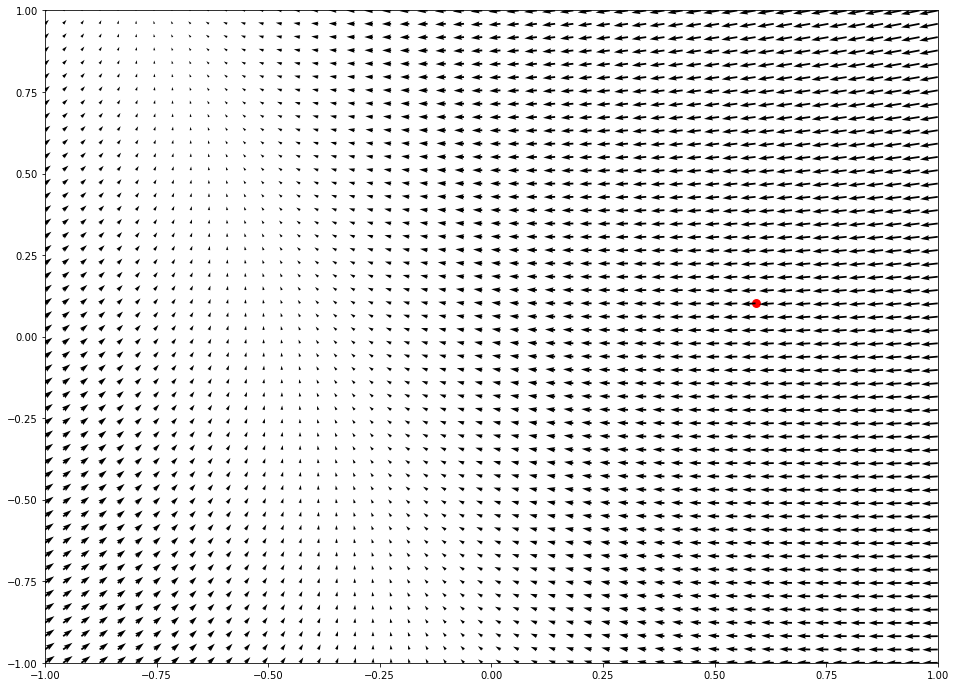

In [158]:
# xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)), axis=-1).reshape(-1, 2)
# idx = np.random.randint(2500)
# obs = np.repeat(logistic_simulator(xx[idx][None,:]),xx.shape[0],axis=0)

score=estimate_fisher_score(torch.tensor(obs).float().to(device),torch.tensor(xx).float().to(device))#.cpu().numpy()
scores_norm = np.linalg.norm(score, axis=-1, ord=2, keepdims=True)
scores_log1p = score / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*xx[idx], color='red', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [165]:
#generate one sample
# test_theta = np.array([[0.2,0.2]])
test_theta = prior_thetas(1)
obs = logistic_simulator(test_theta)   

In [166]:
true_thetas = torch.tensor(np.repeat(test_theta, 10000, axis=0)).float()
true_thetas_samples = logistic_simulator(true_thetas)

In [167]:
true_fs=true_fisher_score(test_theta,obs)
true_fisher_matrix=true_fisher_information(test_theta)

In [168]:
#calcuate the fisher score at (test_theta,obs)
estimate_fs=estimate_fisher_score(torch.tensor(obs).float().to(device),torch.tensor(test_theta).float().to(device))#.cpu().numpy()

#calcuate the fisher score at every sample in true_thetas_samples
temp_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))#.cpu().numpy()
#estimate fisher matrix through averaging
estimate_fisher_matrix=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

/tmp/ipykernel_2093203/159782675.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))#.cpu().numpy()


In [169]:
true_fs,estimate_fs

(array([[-0.54083635, -0.31385179]]),
 array([[-0.7901262 , -0.28460896]], dtype=float32))

In [170]:
true_fisher_matrix,estimate_fisher_matrix

(array([[[2.3766577 , 0.61943442],
         [0.61943442, 0.24816092]]]),
 array([[3.5004516 , 1.1879399 ],
        [1.1879399 , 0.49082482]], dtype=float32))

In [171]:
xx = np.stack(np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50)), axis=-1).reshape(-1, 2)
true_fm=true_fisher_information(xx)
estimated_fm=np.zeros_like(true_fm)
for idx,one_x in enumerate(xx):
    estimated_fm[idx]=estimate_fisher_information(one_x[np.newaxis,:])

# Perform the plots
# plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
# plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

/tmp/ipykernel_2093203/3199518193.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))


In [172]:
true_fm.shape,estimated_fm.shape    

((2500, 2, 2), (2500, 2, 2))

In [173]:
idx=np.random.randint(50*50)
true_fm[idx],estimated_fm[idx],xx[idx]


(array([[1.94725879, 0.49294693],
        [0.49294693, 0.19774398]]),
 array([[2.41208196, 0.66903543],
        [0.66903543, 0.26474288]]),
 array([0.75510204, 0.95918367]))

Text(0.5, 1.0, 'Fisher matrix 1,1')

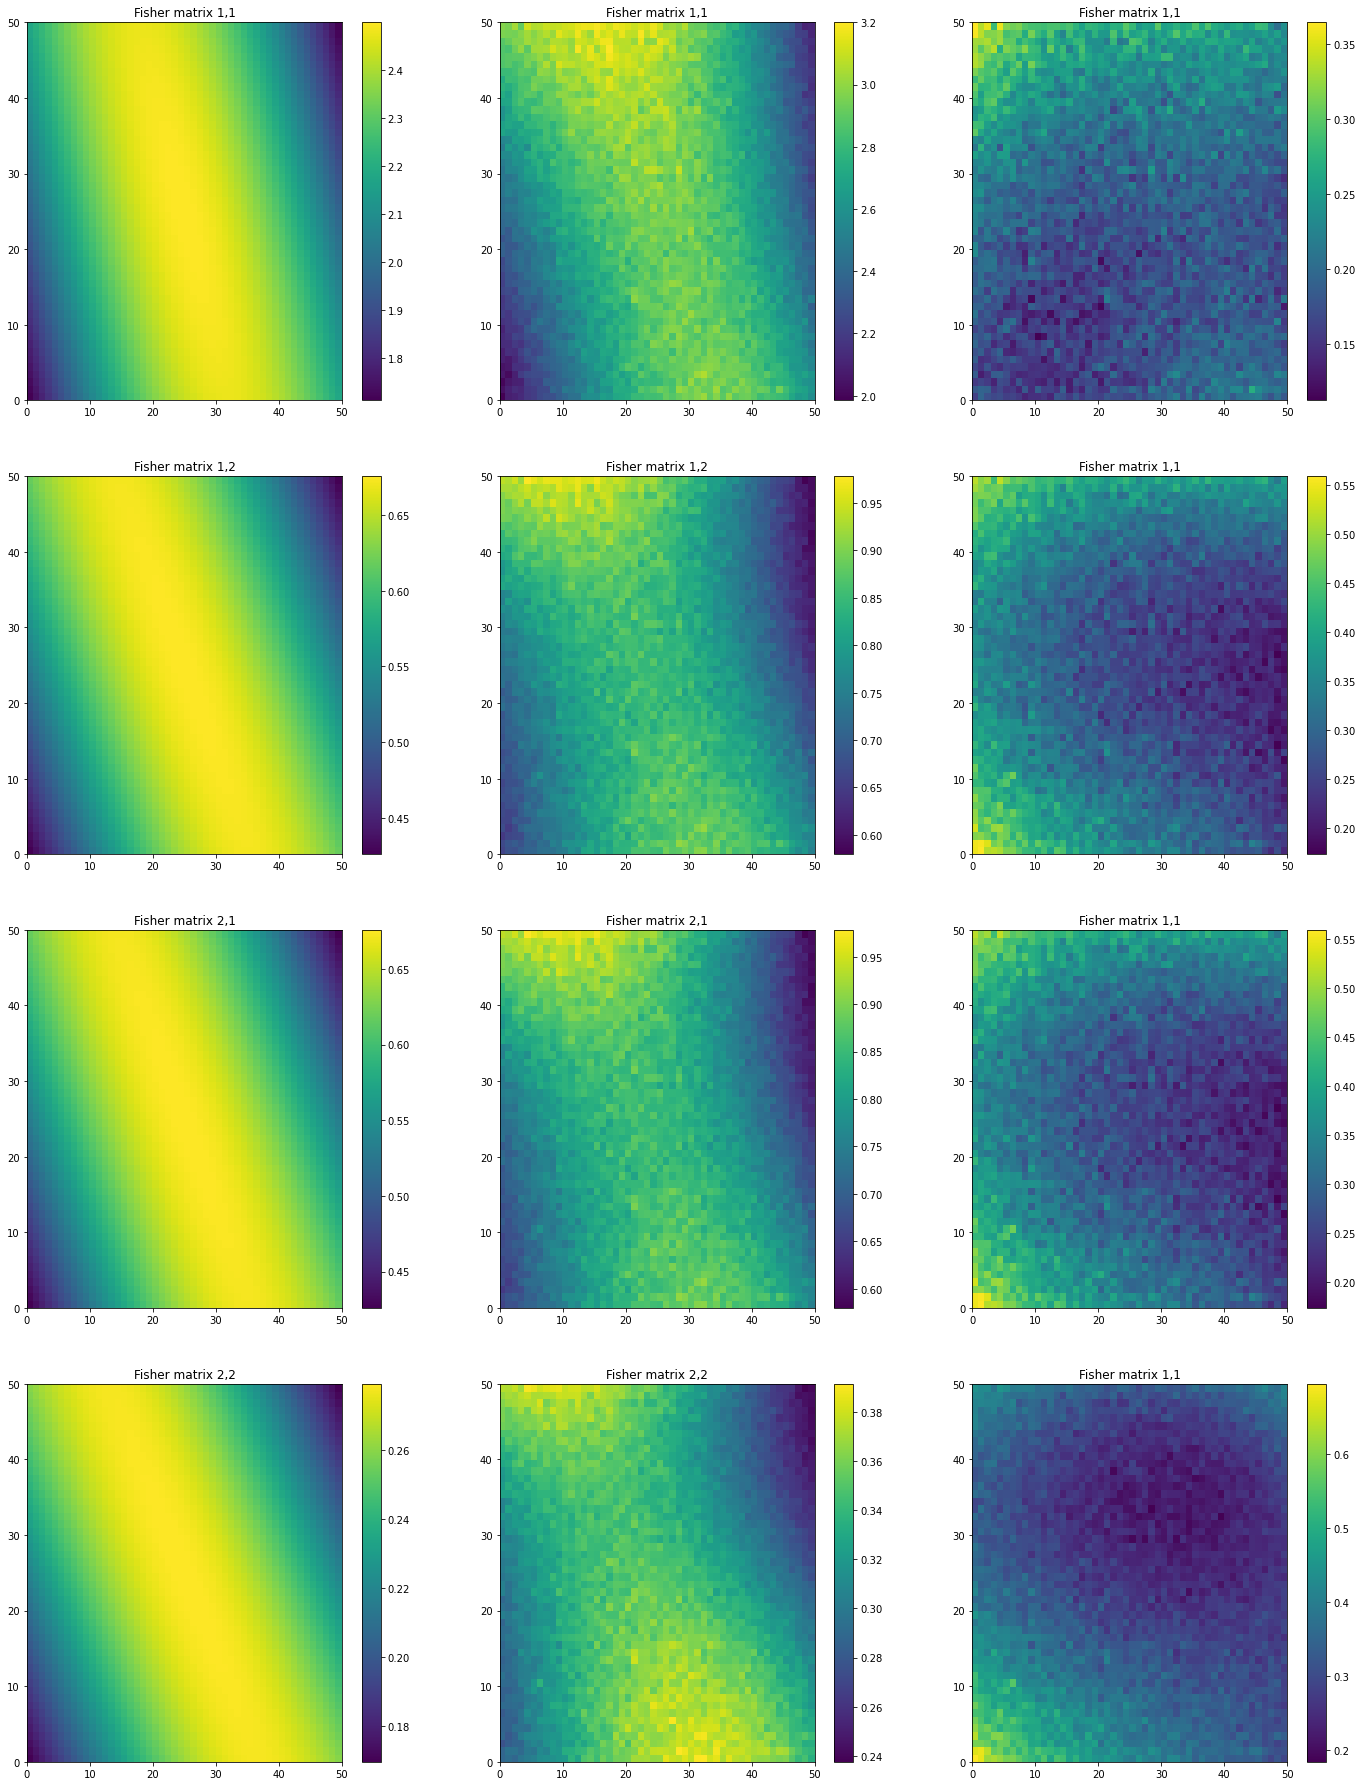

In [178]:


plt.figure(figsize=(24,32))
plt.subplot(4,3,1)
plt.pcolor(true_fm[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,3,2)
plt.pcolor(estimated_fm[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,3,3)
plt.pcolor(((estimated_fm[:,0,0]-true_fm[:,0,0])/true_fm[:,0,0]).reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,3,4)
plt.pcolor(true_fm[:,0,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,2')

plt.subplot(4,3,5)
plt.pcolor(estimated_fm[:,0,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,2')

plt.subplot(4,3,6)
plt.pcolor(((estimated_fm[:,0,1]-true_fm[:,0,1])/true_fm[:,0,1]).reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,3,7)
plt.pcolor(true_fm[:,1,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,1')

plt.subplot(4,3,8)
plt.pcolor(estimated_fm[:,1,0].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,1')

plt.subplot(4,3,9)
plt.pcolor(((estimated_fm[:,1,0]-true_fm[:,1,0])/true_fm[:,1,0]).reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

plt.subplot(4,3,10)
plt.pcolor(true_fm[:,1,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,2')

plt.subplot(4,3,11)
plt.pcolor(estimated_fm[:,1,1].reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 2,2')

plt.subplot(4,3,12)
plt.pcolor(((estimated_fm[:,1,1]-true_fm[:,1,1])/true_fm[:,1,1]).reshape(50,50))
plt.colorbar()
plt.title('Fisher matrix 1,1')

